# Entrenamiento YOLOv8 - Detección de Anomalías Dentales

**Optimizado para RTX 3050 (4GB VRAM) + 16GB RAM**

Este notebook entrena un modelo YOLOv8 para detectar múltiples anomalías dentales en radiografías panorámicas.

## Características:
- ✅ YOLOv8n (nano) - optimizado para GPUs pequeñas
- ✅ Mixed Precision (FP16) automático
- ✅ Data augmentation optimizado para radiografías
- ✅ Early stopping y checkpointing
- ✅ Métricas de detección (mAP, Precision, Recall)
- ✅ Visualización de resultados

## Clases a Detectar:
1. Cordal
2. Apiñamiento
3. Diente rotado
4. Diastema
5. Dentula
6. Zona desdentada
7. Tratamiento de conducto
8. Fractura
9. Caries
10. Enanismo reticular
11. Quiste odontogénico

## 1. Instalación y Setup

In [1]:
# Instalar ultralytics (YOLOv8) si no está instalado
import sys
import subprocess

try:
    import ultralytics
    print(f"✓ Ultralytics ya instalado (versión {ultralytics.__version__})")
except ImportError:
    print("Instalando ultralytics...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])
    print("✓ Ultralytics instalado")

✓ Ultralytics ya instalado (versión 8.3.220)


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

from ultralytics import YOLO
from ultralytics import settings

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Importaciones completadas")

✓ Importaciones completadas


## 2. Verificar GPU y Configuración

In [3]:
print("=" * 80)
print("CONFIGURACIÓN DE GPU - RTX 3050 OPTIMIZADA")
print("=" * 80)

if torch.cuda.is_available():
    print(f"✓ PyTorch version: {torch.__version__}")
    print(f"✓ CUDA version: {torch.version.cuda}")
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ VRAM Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"✓ VRAM Disponible: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")
    
    # Limpiar cache
    torch.cuda.empty_cache()
    
    device = 0  # GPU 0
    print(f"\n✓ Dispositivo seleccionado: CUDA:{device}")
else:
    print("⚠️ GPU no disponible - usando CPU (será MUY lento)")
    device = 'cpu'

print("=" * 80)

CONFIGURACIÓN DE GPU - RTX 3050 OPTIMIZADA
✓ PyTorch version: 2.5.1+cu121
✓ CUDA version: 12.1
✓ GPU: NVIDIA GeForce RTX 3050 Laptop GPU
✓ VRAM Total: 4.29 GB
✓ VRAM Disponible: 4.29 GB

✓ Dispositivo seleccionado: CUDA:0


## 3. Verificar Dataset

In [5]:
# Ruta al archivo de configuración del dataset
data_yaml_path = Path('../data.yml')

if not data_yaml_path.exists():
    print(f"⚠️ ERROR: No se encontró {data_yaml_path}")
else:
    # Leer configuración
    with open(data_yaml_path, 'r', encoding='utf-8') as f:
        data_config = yaml.safe_load(f)
    
    print("✓ Configuración del dataset:")
    print(f"  • Número de clases: {data_config['nc']}")
    print(f"  • Clases: {data_config['names']}")
    print(f"\n  • Train: {data_config['train']}")
    print(f"  • Val: {data_config['val']}")
    print(f"  • Test: {data_config['test']}")
    
    # Verificar que existen los directorios
    base_dir = Path('..')
    
    train_images = list((base_dir / 'train' / 'images').glob('*.png')) + list((base_dir / 'train' / 'images').glob('*.jpg'))
    val_images = list((base_dir / 'val' / 'images').glob('*.png')) + list((base_dir / 'val' / 'images').glob('*.jpg'))
    test_images = list((base_dir / 'test' / 'images').glob('*.png')) + list((base_dir / 'test' / 'images').glob('*.jpg'))
    
    print(f"\n✓ Imágenes encontradas:")
    print(f"  • Train: {len(train_images)} imágenes")
    print(f"  • Val: {len(val_images)} imágenes")
    print(f"  • Test: {len(test_images)} imágenes")
    print(f"  • Total: {len(train_images) + len(val_images) + len(test_images)} imágenes")

✓ Configuración del dataset:
  • Número de clases: 11
  • Clases: ['cordal', 'apinamiento', 'diente_rotado', 'diastema', 'dentula', 'zona_dentula', 'tratamiento_conducto', 'fractura', 'caries', 'enanismo_reticular', 'quiste_ontogenico']

  • Train: ./train/images
  • Val: ./val/images
  • Test: ./test/images

✓ Imágenes encontradas:
  • Train: 31 imágenes
  • Val: 6 imágenes
  • Test: 8 imágenes
  • Total: 45 imágenes


## 4. Visualizar Ejemplos del Dataset

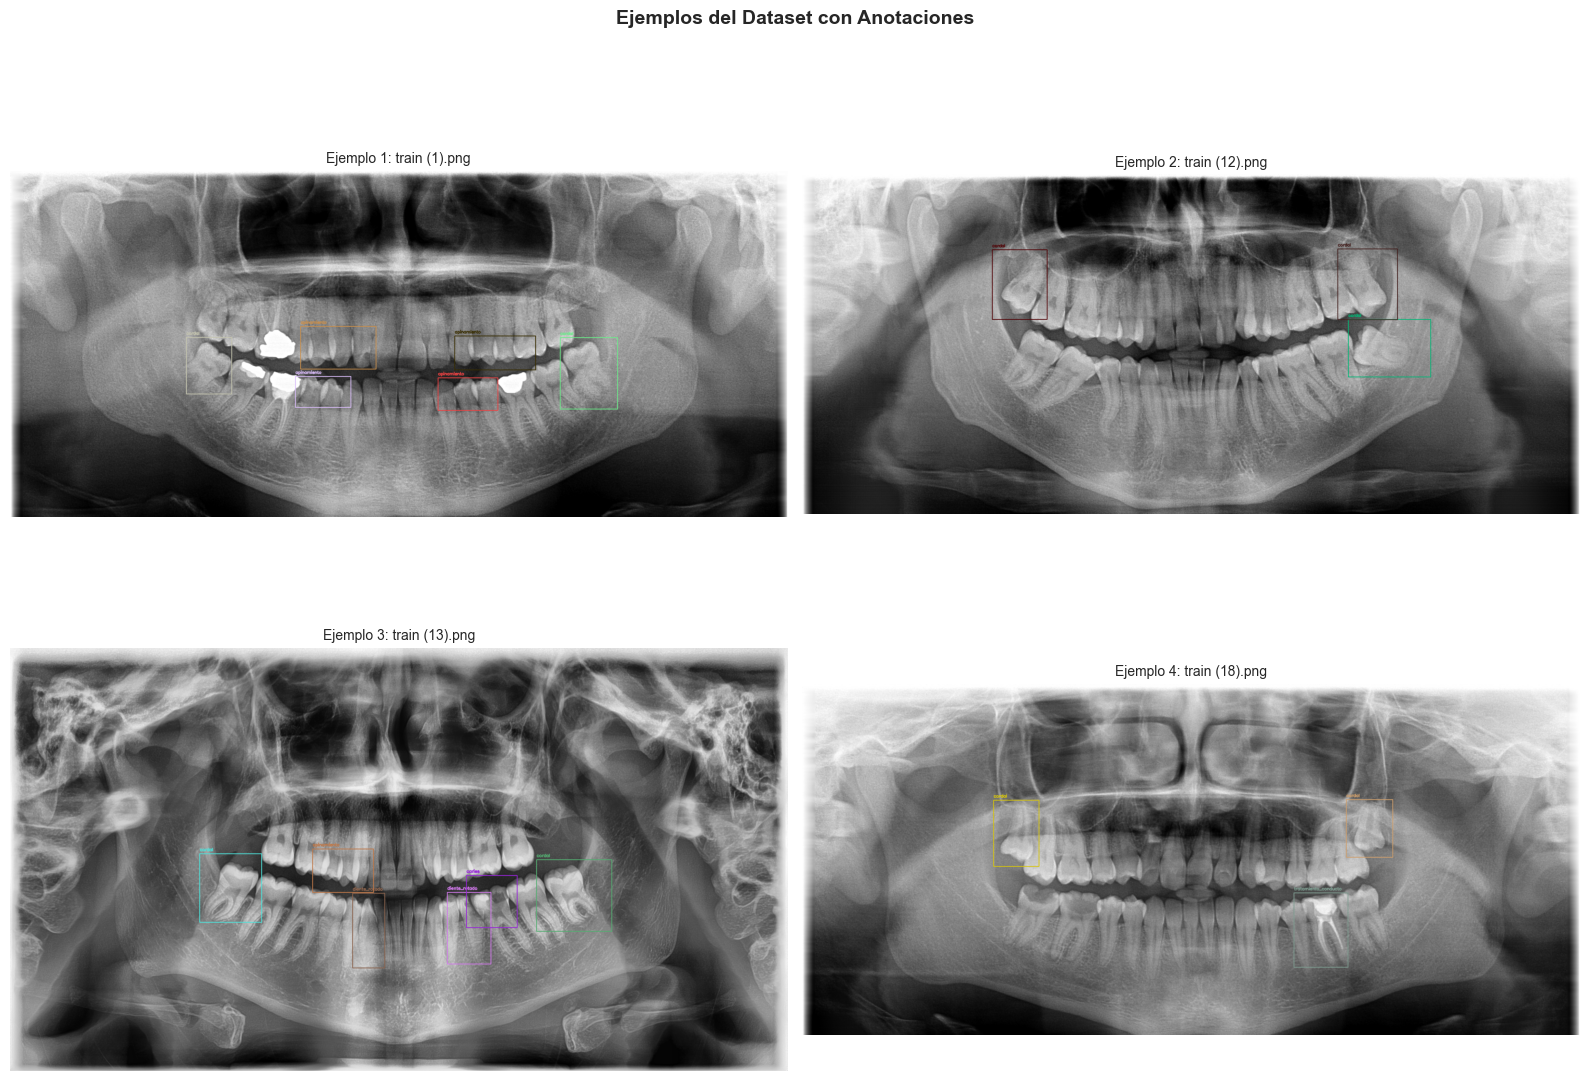

In [6]:
def visualize_yolo_annotations(image_path, label_path, class_names, max_boxes=50):
    """Visualiza una imagen con sus anotaciones YOLO."""
    # Leer imagen
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Leer anotaciones
    if label_path.exists():
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Dibujar cada bounding box
        for line in lines[:max_boxes]:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                
                # Convertir de YOLO a pixel coordinates
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)
                
                # Dibujar
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                
                # Etiqueta
                label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img

# Visualizar algunas imágenes de ejemplo
if len(train_images) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, img_path in enumerate(train_images[:4]):
        # Buscar archivo de etiquetas correspondiente
        label_path = Path(str(img_path).replace('/images/', '/labels/').replace('\\images\\', '\\labels\\').replace('.png', '.txt').replace('.jpg', '.txt'))
        
        # Visualizar
        img_with_boxes = visualize_yolo_annotations(img_path, label_path, data_config['names'])
        
        axes[i].imshow(img_with_boxes)
        axes[i].set_title(f'Ejemplo {i+1}: {img_path.name}', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Ejemplos del Dataset con Anotaciones', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se encontraron imágenes para visualizar")

## 5. Configuración del Entrenamiento (Optimizada para RTX 3050)

In [11]:
# Configuración optimizada para RTX 3050 (4GB VRAM)
CONFIG = {
    # Modelo - YOLO Nano es el más ligero
    'model': 'yolov8m.pt',  # Opciones: yolov8n.pt (nano), yolov8s.pt (small), yolov8m.pt (medium)
    
    # Dataset
    'data': str(data_yaml_path.absolute()),
    
    # Entrenamiento - OPTIMIZADO PARA 4GB VRAM
    'epochs': 100,
    'imgsz': 640,  # Tamaño de imagen (puede reducir a 512 o 384 si da OOM)
    'batch': 8,    # Batch size (ajusta según tu VRAM)
    
    # Optimización GPU
    'device': device,
    'workers': 2,   # Workers para data loading
    'amp': True,    # Mixed Precision (FP16) - CRÍTICO para RTX 3050
    'half': False,  # Se activa automáticamente con amp
    
    # Guardado y logging
    'project': '../runs/detect',
    'name': 'dental_yolov8n',
    'exist_ok': True,
    'save': True,
    'save_period': 10,  # Guardar checkpoint cada 10 épocas
    
    # Optimizaciones de entrenamiento
    'optimizer': 'AdamW',  # Mejor que SGD para datasets pequeños
    'lr0': 0.001,          # Learning rate inicial
    'lrf': 0.01,           # Learning rate final (lr0 * lrf)
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    
    # Data augmentation (optimizado para radiografías)
    'hsv_h': 0.015,        # Hue augmentation (muy bajo para rayos X)
    'hsv_s': 0.2,          # Saturation
    'hsv_v': 0.2,          # Value/brightness
    'degrees': 10.0,       # Rotación ±10 grados
    'translate': 0.1,      # Traslación
    'scale': 0.2,          # Escala
    'shear': 5.0,          # Shear
    'perspective': 0.0,    # Sin perspectiva (radiografías son planas)
    'flipud': 0.0,         # No flip vertical (anatomía tiene orientación)
    'fliplr': 0.5,         # Flip horizontal (50% - simetría dental)
    'mosaic': 1.0,         # Mosaic augmentation
    'mixup': 0.1,          # Mixup augmentation
    'copy_paste': 0.0,     # No copy-paste para este caso
    
    # Early stopping y paciencia
    'patience': 20,        # Parar si no mejora en 20 épocas
    
    # Validación
    'val': True,
    'plots': True,         # Generar gráficas
    'verbose': True,
    
    # Métricas
    'conf': 0.25,          # Confidence threshold para predicciones
    'iou': 0.7,            # IoU threshold para NMS
}

print("=" * 80)
print("CONFIGURACIÓN DEL ENTRENAMIENTO - YOLOv8")
print("=" * 80)
print(f"Modelo: {CONFIG['model']}")
print(f"Imagen: {CONFIG['imgsz']}x{CONFIG['imgsz']}")
print(f"Batch size: {CONFIG['batch']}")
print(f"Épocas: {CONFIG['epochs']}")
print(f"Workers: {CONFIG['workers']}")
print(f"Mixed Precision (AMP): {CONFIG['amp']}")
print(f"Device: {CONFIG['device']}")
print(f"Optimizer: {CONFIG['optimizer']}")
print(f"Learning Rate: {CONFIG['lr0']} → {CONFIG['lr0'] * CONFIG['lrf']}")
print(f"Early Stopping Patience: {CONFIG['patience']} épocas")
print("\n⚡ Configuración optimizada para RTX 3050 (4GB VRAM)")
print("=" * 80)

CONFIGURACIÓN DEL ENTRENAMIENTO - YOLOv8
Modelo: yolov8m.pt
Imagen: 640x640
Batch size: 8
Épocas: 100
Workers: 2
Mixed Precision (AMP): True
Device: 0
Optimizer: AdamW
Learning Rate: 0.001 → 1e-05
Early Stopping Patience: 20 épocas

⚡ Configuración optimizada para RTX 3050 (4GB VRAM)


## 6. Crear Modelo YOLOv8

In [12]:
# Cargar modelo YOLOv8
print(f"Cargando modelo {CONFIG['model']}...")
model = YOLO(CONFIG['model'])

print(f"\n✓ Modelo cargado: {CONFIG['model']}")
print(f"  • Tipo: YOLOv8 Nano (optimizado para velocidad)")
print(f"  • Parámetros: ~{sum(p.numel() for p in model.model.parameters()) / 1e6:.1f}M")
print(f"  • Pre-entrenado: COCO dataset (transferencia de aprendizaje)")
print(f"\n📝 Nota: El modelo se ajustará automáticamente a {data_config['nc']} clases")

Cargando modelo yolov8m.pt...

✓ Modelo cargado: yolov8m.pt
  • Tipo: YOLOv8 Nano (optimizado para velocidad)
  • Parámetros: ~25.9M
  • Pre-entrenado: COCO dataset (transferencia de aprendizaje)

📝 Nota: El modelo se ajustará automáticamente a 11 clases


## 7. Entrenar Modelo 🚀

**IMPORTANTE**: Este proceso tomará tiempo dependiendo de:
- Número de imágenes en tu dataset
- Configuración de épocas (100)
- Hardware (RTX 3050)

**Tiempo estimado**: 2-5 horas para 100 épocas con dataset pequeño-mediano

In [13]:
import time
from datetime import datetime

print("=" * 80)
print("INICIANDO ENTRENAMIENTO - YOLOv8")
print("=" * 80)
print(f"Fecha/Hora inicio: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)
print("\n⏳ Esto puede tomar varias horas...")
print("💡 Tip: No uses el PC para tareas pesadas mientras entrena\n")

start_time = time.time()

# ENTRENAR
results = model.train(
    data=CONFIG['data'],
    epochs=CONFIG['epochs'],
    imgsz=CONFIG['imgsz'],
    batch=CONFIG['batch'],
    device=CONFIG['device'],
    workers=CONFIG['workers'],
    amp=CONFIG['amp'],
    project=CONFIG['project'],
    name=CONFIG['name'],
    exist_ok=CONFIG['exist_ok'],
    save=CONFIG['save'],
    save_period=CONFIG['save_period'],
    optimizer=CONFIG['optimizer'],
    lr0=CONFIG['lr0'],
    lrf=CONFIG['lrf'],
    momentum=CONFIG['momentum'],
    weight_decay=CONFIG['weight_decay'],
    warmup_epochs=CONFIG['warmup_epochs'],
    warmup_momentum=CONFIG['warmup_momentum'],
    warmup_bias_lr=CONFIG['warmup_bias_lr'],
    hsv_h=CONFIG['hsv_h'],
    hsv_s=CONFIG['hsv_s'],
    hsv_v=CONFIG['hsv_v'],
    degrees=CONFIG['degrees'],
    translate=CONFIG['translate'],
    scale=CONFIG['scale'],
    shear=CONFIG['shear'],
    perspective=CONFIG['perspective'],
    flipud=CONFIG['flipud'],
    fliplr=CONFIG['fliplr'],
    mosaic=CONFIG['mosaic'],
    mixup=CONFIG['mixup'],
    copy_paste=CONFIG['copy_paste'],
    patience=CONFIG['patience'],
    val=CONFIG['val'],
    plots=CONFIG['plots'],
    verbose=CONFIG['verbose'],
    conf=CONFIG['conf'],
    iou=CONFIG['iou']
)

end_time = time.time()
total_time = end_time - start_time

print("\n" + "=" * 80)
print("ENTRENAMIENTO COMPLETADO ✅")
print("=" * 80)
print(f"Fecha/Hora fin: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Tiempo total: {total_time/3600:.2f} horas ({total_time/60:.1f} minutos)")
print(f"Tiempo por época: {total_time/CONFIG['epochs']:.1f} segundos")
print("=" * 80)

INICIANDO ENTRENAMIENTO - YOLOv8
Fecha/Hora inicio: 2025-10-23 01:12:14

⏳ Esto puede tomar varias horas...
💡 Tip: No uses el PC para tareas pesadas mientras entrena

Ultralytics 8.3.220  Python-3.12.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=0.25, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\notebooks\..\data.yml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2, hsv_v=0.2, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4

## 8. Resultados del Entrenamiento

In [14]:
# Directorio de resultados
results_dir = Path(CONFIG['project']) / CONFIG['name']
print(f"📁 Directorio de resultados: {results_dir}\n")

# Mostrar métricas finales
print("=" * 80)
print("MÉTRICAS FINALES")
print("=" * 80)

# Las métricas están en results.results_dict
metrics = results.results_dict
print(f"\n📊 Métricas de Detección:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):
        print(f"  • {key}: {value:.4f}")

print("\n" + "=" * 80)

📁 Directorio de resultados: ..\runs\detect\dental_yolov8n

MÉTRICAS FINALES

📊 Métricas de Detección:
  • metrics/precision(B): 0.7846
  • metrics/recall(B): 0.4090
  • metrics/mAP50(B): 0.5939
  • metrics/mAP50-95(B): 0.4078
  • fitness: 0.4078



## 9. Visualizar Curvas de Entrenamiento

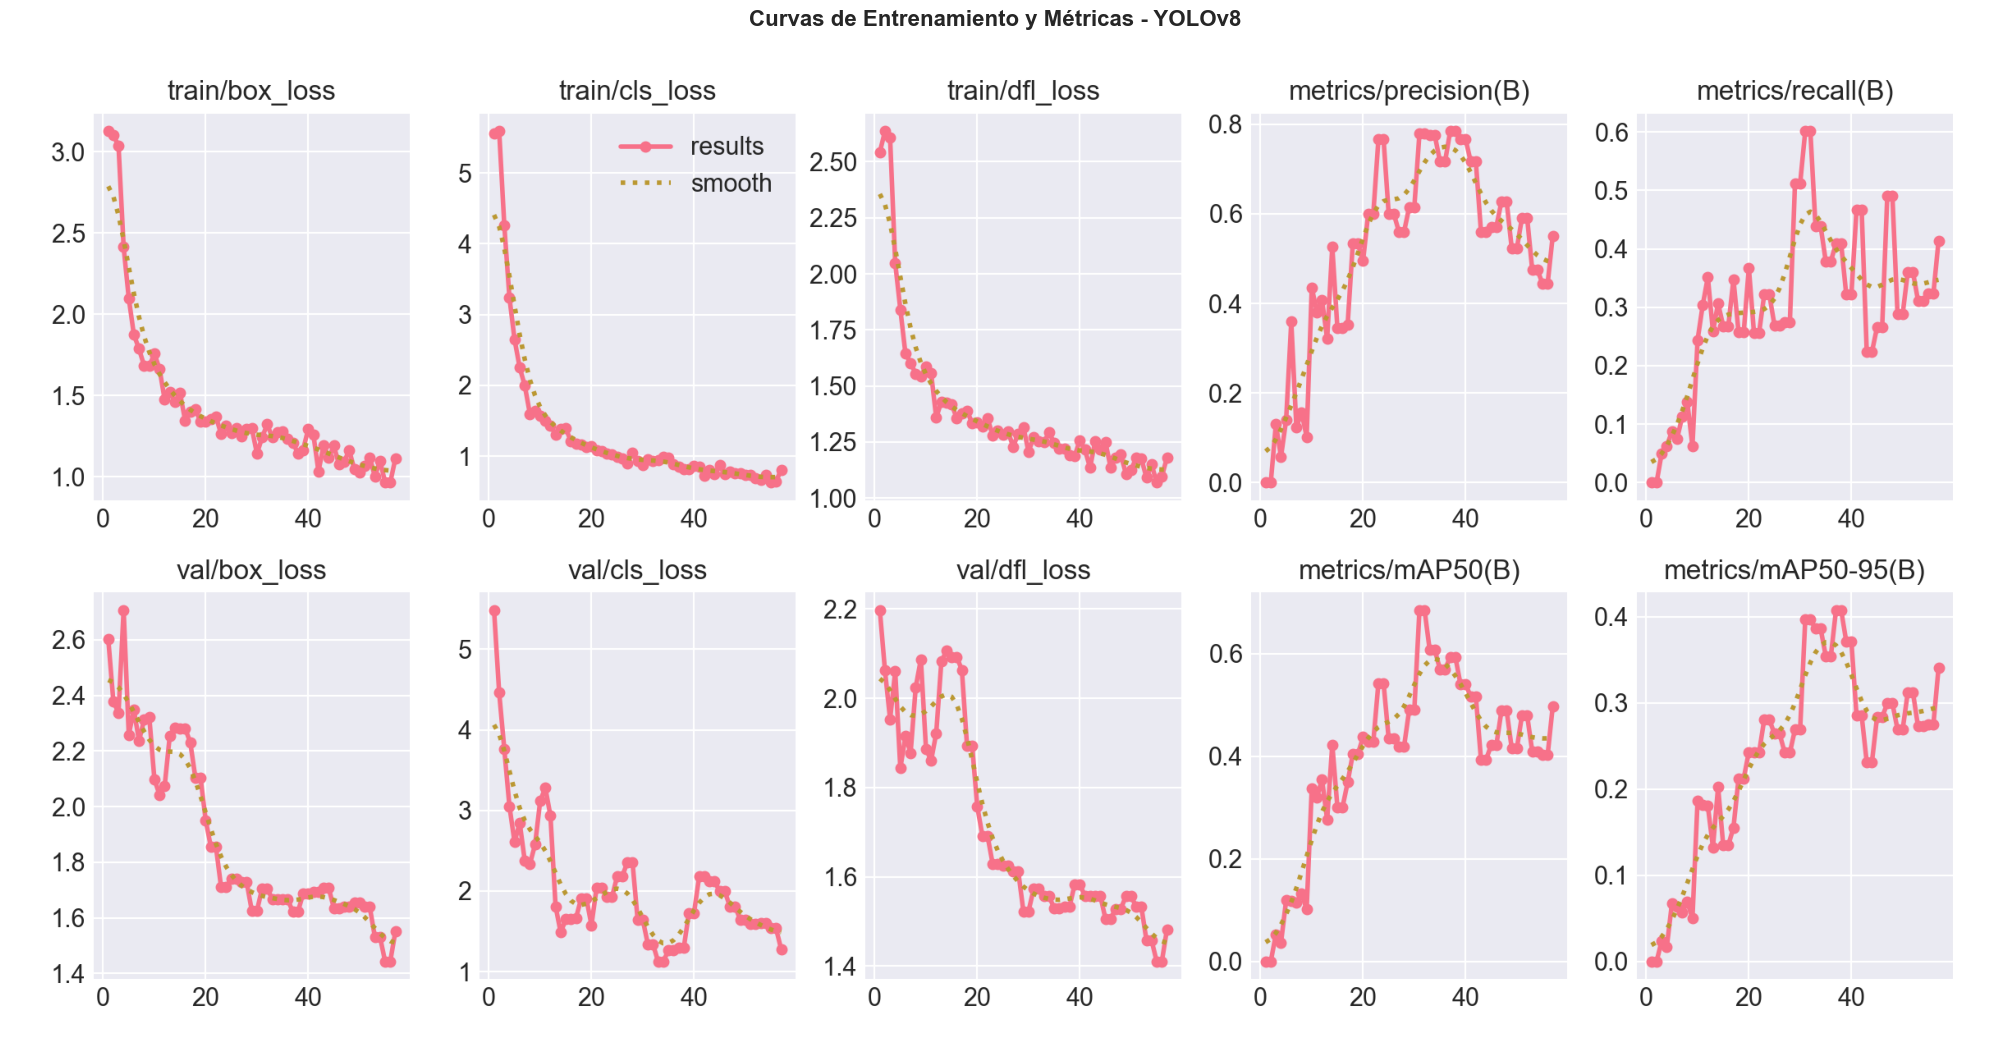

In [15]:
# Cargar imagen de resultados generada por YOLO
results_img_path = results_dir / 'results.png'

if results_img_path.exists():
    img = Image.open(results_img_path)
    
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Curvas de Entrenamiento y Métricas - YOLOv8', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ No se encontró {results_img_path}")
    print("Las gráficas se generaron en el directorio de resultados.")

## 10. Confusion Matrix

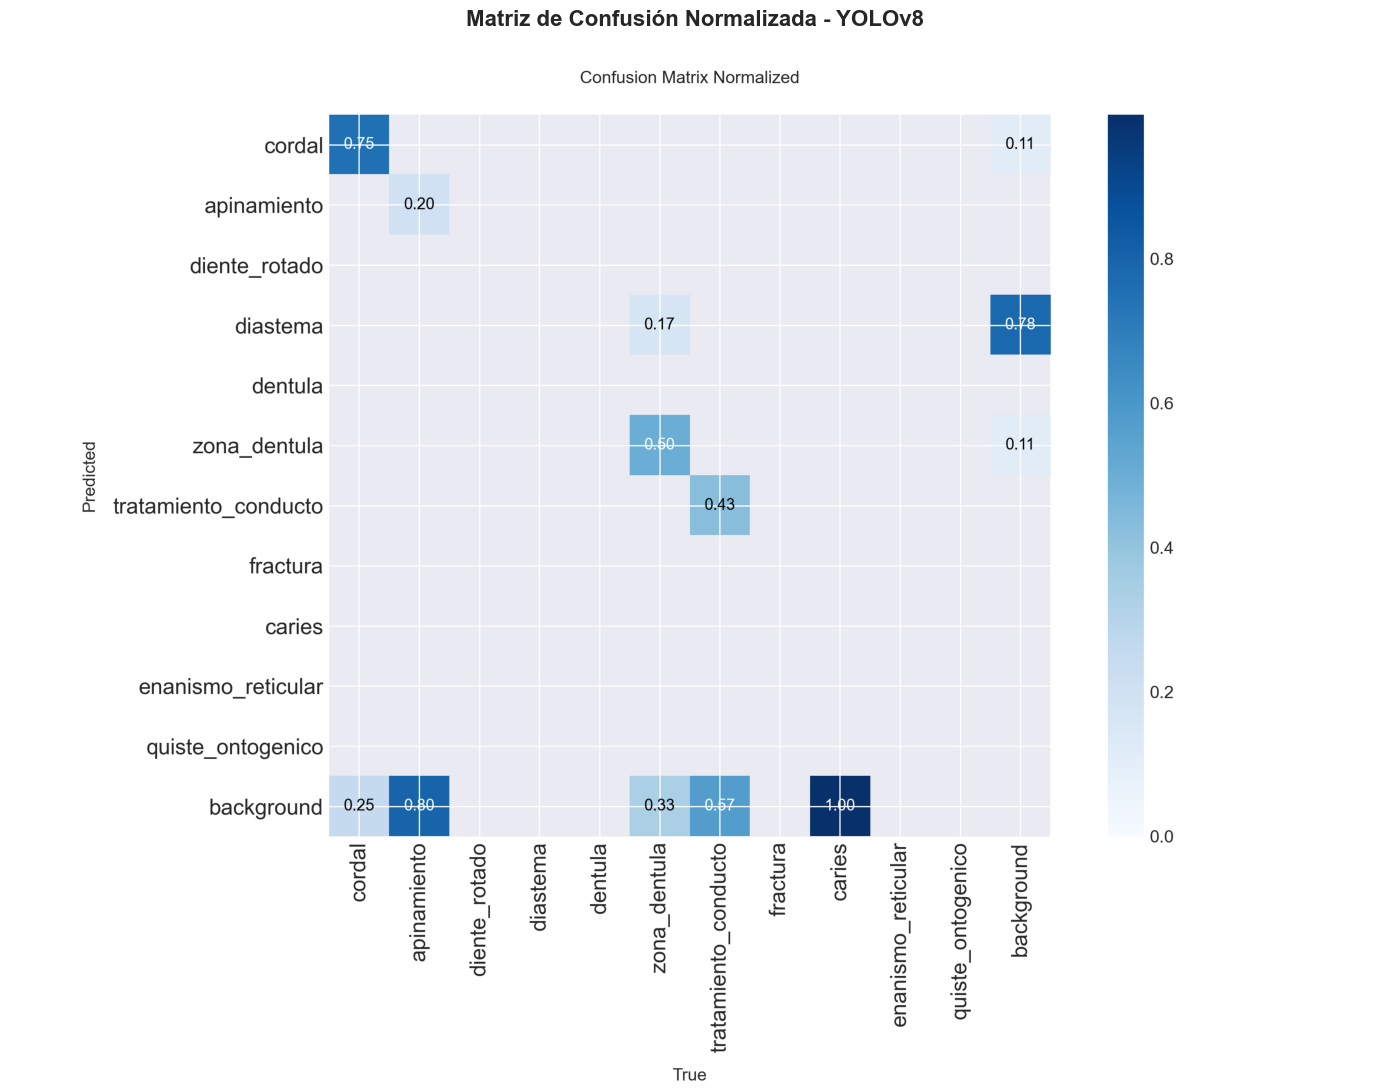

In [16]:
# Cargar matriz de confusión
confusion_matrix_path = results_dir / 'confusion_matrix_normalized.png'

if confusion_matrix_path.exists():
    img = Image.open(confusion_matrix_path)
    
    fig, ax = plt.subplots(figsize=(14, 12))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Matriz de Confusión Normalizada - YOLOv8', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ No se encontró matriz de confusión en {confusion_matrix_path}")

## 11. Validar en Test Set

In [17]:
print("Validando en test set...\n")

# Cargar mejor modelo
best_model_path = results_dir / 'weights' / 'best.pt'
model_best = YOLO(best_model_path)

# Validar
test_results = model_best.val(
    data=CONFIG['data'],
    split='test',
    imgsz=CONFIG['imgsz'],
    batch=CONFIG['batch'],
    conf=CONFIG['conf'],
    iou=CONFIG['iou'],
    device=CONFIG['device']
)

print("\n" + "=" * 80)
print("RESULTADOS EN TEST SET")
print("=" * 80)
print(f"\n📊 Métricas de Test:")
for key, value in test_results.results_dict.items():
    if isinstance(value, (int, float)):
        print(f"  • {key}: {value:.4f}")
print("\n" + "=" * 80)

Validando en test set...

Ultralytics 8.3.220  Python-3.12.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 92 layers, 25,846,129 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.30.2 ms, read: 942.9113.9 MB/s, size: 2463.4 KB)
val: Scanning C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\test\labels.cache... 8 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 8/8 6.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.3it/s 3.7s
                   all          8         33        0.5      0.311       0.43      0.288
                cordal          6         18          1      0.611      0.806      0.537
           apinamiento          2          3          0          0          0          0
         diente_rotado          1          1          0          0          0          0
              diastema          2          2       

## 12. Ejemplos de Predicciones

Realizando predicciones en imágenes de test...



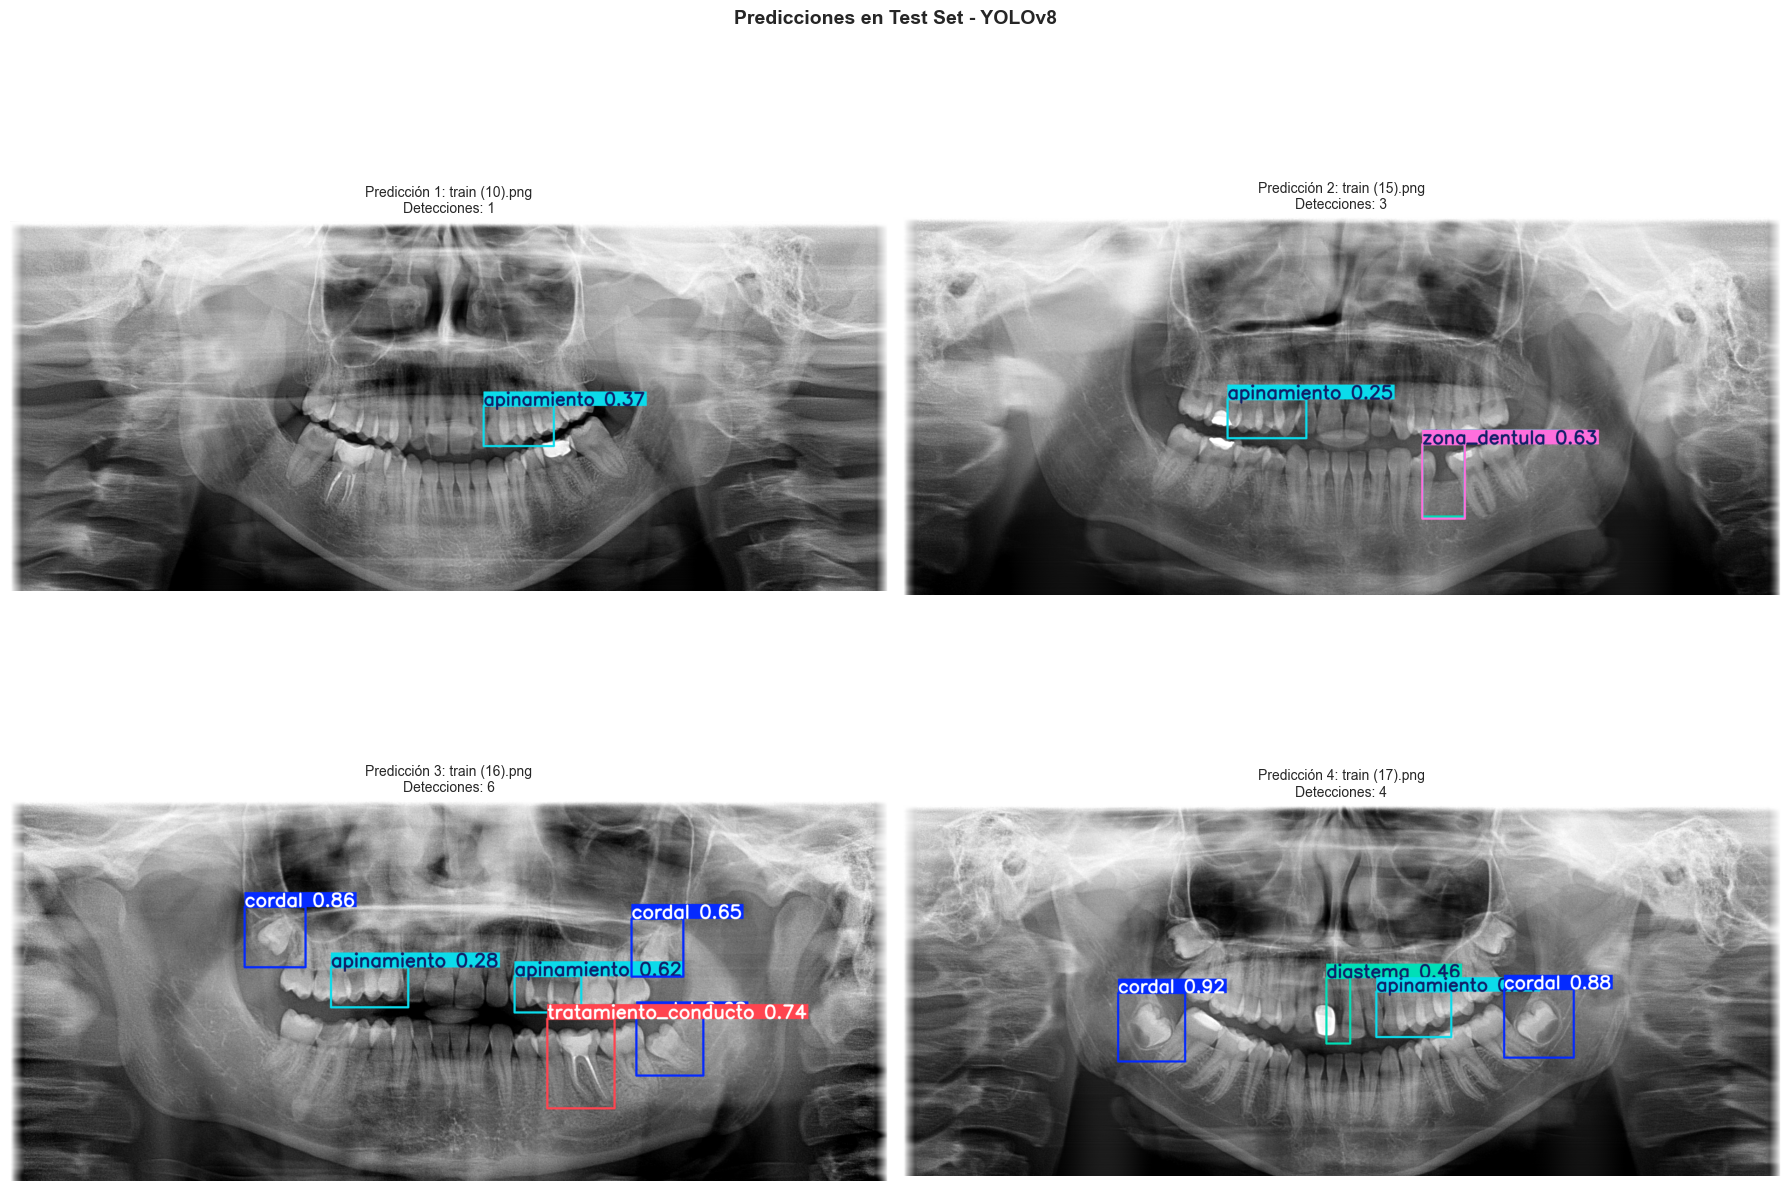


DETALLES DE DETECCIONES

Imagen 1: train (10).png
  Total de detecciones: 1
    1. apinamiento: 37.40% confianza

Imagen 2: train (15).png
  Total de detecciones: 3
    1. zona_dentula: 63.31% confianza
    2. diastema: 28.48% confianza
    3. apinamiento: 25.09% confianza

Imagen 3: train (16).png
  Total de detecciones: 6
    1. cordal: 86.13% confianza
    2. tratamiento_conducto: 73.61% confianza
    3. cordal: 67.91% confianza
    4. cordal: 64.69% confianza
    5. apinamiento: 61.57% confianza
    6. apinamiento: 28.49% confianza

Imagen 4: train (17).png
  Total de detecciones: 4
    1. cordal: 92.23% confianza
    2. cordal: 88.35% confianza
    3. apinamiento: 51.34% confianza
    4. diastema: 45.58% confianza


In [18]:
# Hacer predicciones en imágenes de test
if len(test_images) > 0:
    print("Realizando predicciones en imágenes de test...\n")
    
    # Seleccionar algunas imágenes
    sample_images = test_images[:min(4, len(test_images))]
    
    # Predecir
    predictions = model_best.predict(
        source=[str(img) for img in sample_images],
        conf=CONFIG['conf'],
        iou=CONFIG['iou'],
        imgsz=CONFIG['imgsz'],
        device=CONFIG['device'],
        save=False,
        verbose=False
    )
    
    # Visualizar
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for i, (pred, img_path) in enumerate(zip(predictions, sample_images)):
        # Obtener imagen con predicciones
        img_with_pred = pred.plot()  # Dibuja las predicciones
        img_with_pred = cv2.cvtColor(img_with_pred, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img_with_pred)
        axes[i].set_title(f'Predicción {i+1}: {img_path.name}\nDetecciones: {len(pred.boxes)}', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Predicciones en Test Set - YOLOv8', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Mostrar detalles de detecciones
    print("\n" + "=" * 80)
    print("DETALLES DE DETECCIONES")
    print("=" * 80)
    for i, pred in enumerate(predictions):
        print(f"\nImagen {i+1}: {sample_images[i].name}")
        print(f"  Total de detecciones: {len(pred.boxes)}")
        
        if len(pred.boxes) > 0:
            for j, box in enumerate(pred.boxes):
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                cls_name = data_config['names'][cls_id]
                print(f"    {j+1}. {cls_name}: {conf:.2%} confianza")
        else:
            print("    (Sin detecciones)")
else:
    print("⚠️ No hay imágenes de test disponibles")

## 13. Exportar Modelo para Producción (Opcional)

In [ ]:
# Exportar a ONNX para deployment
print("Exportando modelo a formato ONNX...\n")

onnx_path = model_best.export(
    format='onnx',
    imgsz=CONFIG['imgsz'],
    dynamic=False,
    simplify=True
)

print(f"\n✓ Modelo exportado a: {onnx_path}")
print("  Este formato puede usarse para deployment en producción")

## 14. Resumen Final

In [ ]:
print("\n" + "=" * 80)
print("RESUMEN FINAL DEL ENTRENAMIENTO - YOLOv8")
print("=" * 80)

print(f"\n📊 Configuración:")
print(f"  • Modelo: {CONFIG['model']}")
print(f"  • Dataset: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")
print(f"  • Clases: {data_config['nc']} ({', '.join(data_config['names'][:3])}...)")
print(f"  • Imagen: {CONFIG['imgsz']}x{CONFIG['imgsz']}")
print(f"  • Batch: {CONFIG['batch']}")
print(f"  • Épocas: {CONFIG['epochs']}")
print(f"  • Tiempo total: {total_time/3600:.2f} horas")

print(f"\n🎯 Resultados:")
print(f"  • mAP50: {test_results.results_dict.get('metrics/mAP50(B)', 0):.4f}")
print(f"  • mAP50-95: {test_results.results_dict.get('metrics/mAP50-95(B)', 0):.4f}")
print(f"  • Precision: {test_results.results_dict.get('metrics/precision(B)', 0):.4f}")
print(f"  • Recall: {test_results.results_dict.get('metrics/recall(B)', 0):.4f}")

print(f"\n�� Archivos generados:")
print(f"  • Mejor modelo: {best_model_path}")
print(f"  • Resultados: {results_dir}")
print(f"  • Gráficas: {results_dir}/results.png")
print(f"  • Matriz confusión: {results_dir}/confusion_matrix_normalized.png")

print(f"\n💡 Próximos pasos:")
print(f"  1. Revisar las gráficas de entrenamiento en: {results_dir}")
print(f"  2. Analizar la matriz de confusión para identificar clases problemáticas")
print(f"  3. Probar predicciones en nuevas imágenes")
print(f"  4. Si el rendimiento no es satisfactorio:")
print(f"     - Aumentar datos de entrenamiento")
print(f"     - Ajustar augmentations")
print(f"     - Probar modelo más grande (yolov8s.pt o yolov8m.pt)")
print(f"     - Ajustar hiperparámetros")

print("\n" + "=" * 80)
print("✅ ENTRENAMIENTO YOLOv8 COMPLETADO EXITOSAMENTE")
print("=" * 80)

## 15. Limpiar Memoria GPU

In [ ]:
# Liberar memoria GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✓ Cache de GPU limpiada")
    print(f"  VRAM disponible: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")

---

## 🎓 Notas Importantes

### Interpretación de Métricas:
- **mAP50**: Mean Average Precision @ IoU=0.5 (métrica principal)
- **mAP50-95**: mAP promediado entre IoU 0.5 a 0.95 (más estricta)
- **Precision**: De las detecciones, cuántas son correctas
- **Recall**: De todos los objetos reales, cuántos fueron detectados

### Valores buenos para detección médica:
- mAP50 > 0.7: Bueno
- mAP50 > 0.8: Muy bueno
- mAP50 > 0.9: Excelente

### Si el entrenamiento es muy lento:
1. Reduce `imgsz` a 512 o 384
2. Reduce `batch` a 4
3. Reduce `workers` a 1
4. Asegúrate que no haya otros programas usando GPU

### Si tienes CUDA Out of Memory:
1. Reduce `batch` a 4 o 2
2. Reduce `imgsz` a 512 o 384
3. Cierra otros programas que usen GPU
4. Reinicia el kernel de Jupyter

### Diferencias entre YOLOv8 y YOLOv11:
- **YOLOv8**: Versión madura y estable, ampliamente probada
- **YOLOv11**: Versión más reciente con mejoras incrementales
- Ambas funcionan de manera similar para este caso de uso